In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sps
import pymc3 as pm

import seaborn as sns
sns.set(font_scale=1.5)

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

Загрузите данные `flats_moscow.txt` о стоимости квартир в Москве

In [2]:
data = pd.read_csv('./flats_moscow.txt', sep='\t', index_col=0)
data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


Постройте график зависимости цены квартиры (price) от ее общей площади (totsp). Что можно сказать о данных?

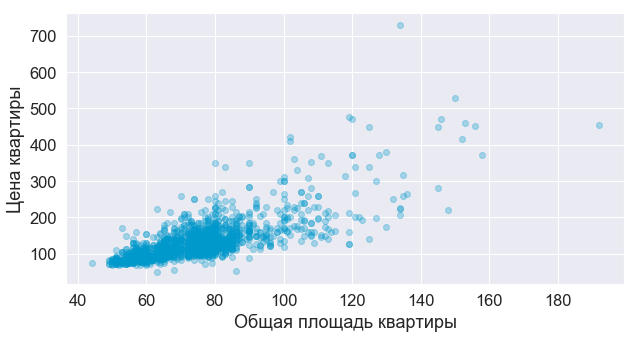

In [3]:
plt.figure(figsize=(10, 5))
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');

Постройте с помощью PyMC линейную регрессию для предсказания цены квартиры (price) от ее общей площади (totsp). Используйте следующие распределения:
* Априорное распределение на коэффициенты --- нормальное с нулевым средним и среднеквадратичным разбросом 20
* Ошибка имеет нормальное распределение с нулевым средним
* Априорное распределение на дисперсию ошибки --- модуль распределения Коши

Запишите модель формулами:

<...>

Реализуйте эту модель и проведите 3000 итераций семплирования

In [6]:
with pm.Model() as model:
    # объявим данные
    x_data = pm.Data('x_data', data['totsp'] )
    
    # априорное распределение параметра
    sigma = pm.HalfCauchy('sigma_noise', 10)
    theta0 = pm.Normal('theta_0', 0, 20)
    theta1 = pm.Normal('theta_1', 0, 20)
    
    # распределение данных
    Y = pm.Normal('Y', mu=x_data*theta1 + theta0, sigma=sigma, observed=data['price'])
    
    trace = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_0, sigma_noise]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:12<00:00, 631.28draws/s]


Постройте `pm.traceplot`. Что можно по нему сказать? Какое апострериорное распределение имеют параметры модели?

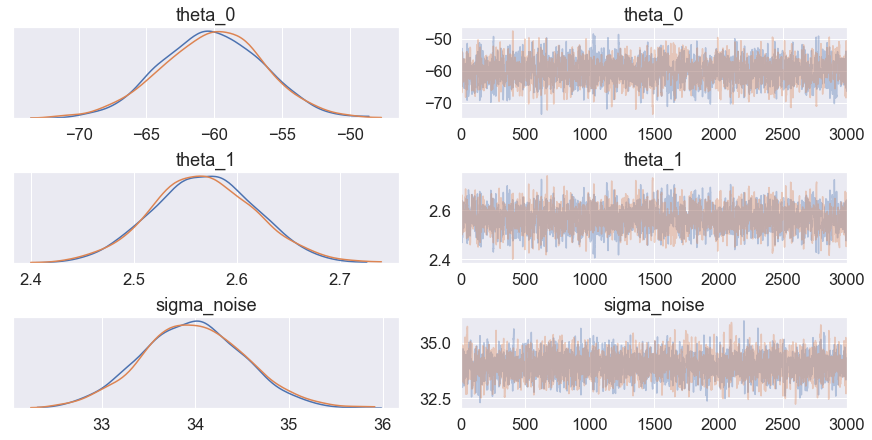

In [7]:
import arviz as az
az.plot_trace(trace);

Теперь вам нужно построить предсказательный интервал для каждого $x$, взяв область, в которую попадает 95% вероятностной массы апостериорного распределения. Иначе говоря, на основе построенной модели нужно для каждой площади квартиры $x$ вычислить 95%-й диаппазон цен на квартиры с такой мощностью.

Для выполнения этого пункта задайте сетку значений площади квартиры и с помощью `pm.sample_posterior_predictive` проведите 10000 итераций семплирования из предиктивного распределения.

In [8]:
new_x = np.arange(40, 180)
with model:
    pm.set_data({'x_data': new_x})
    
    y_test = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:23<00:00, 423.22it/s]


Какой размерности получится объект?

In [9]:
y_test['Y'].shape

(10000, 140)

На основе полученных семплов постройте график предсказательного интервала. Для этого можно взять квантили у семплов для каждого $x$.

In [11]:
conv_int = []
for elem in y_test['Y'].T:
    conv_int.append([np.percentile(elem, 2.5), np.percentile(elem, 100 - 2.5)])

conv_int = np.array(conv_int)

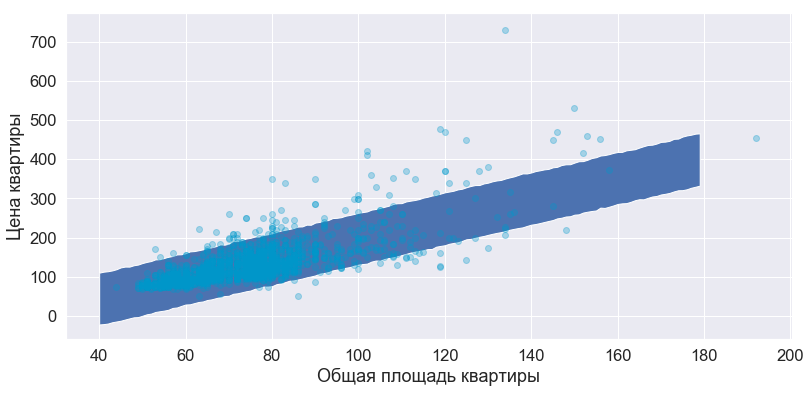

In [13]:
plt.figure(figsize=(13, 6))
plt.fill_between(new_x, y1=conv_int[:,0], y2=conv_int[:,1])
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');
plt.show()

Что вы можете сказать по этому графику?

Предложите способ, как исправить модель. Реализуйте эту модель, постройте для нее график предсказательного интервала.

In [59]:
with pm.Model() as model:
    # объявим данные
    x_data = pm.Data('x_data', data['totsp'] )
    
    # априорное распределение параметра
    sigma_1 = pm.Normal('sigma_noise1', 1, 1)
    sigma_0 = pm.HalfCauchy('sigma_noise0', 10)
    theta0 = pm.Normal('theta_0', 0, 20)
    theta1 = pm.Normal('theta_1', 0, 20)
    
    # распределение данных
    Y = pm.Normal('Y', mu=x_data*theta1 + theta0, sigma=sigma_1 * x_data + sigma_0, observed=data['price'])
    
    trace = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_0, sigma_noise0, sigma_noise1]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:30<00:00, 262.34draws/s]
The acceptance probability does not match the target. It is 0.88152711920062, but should be close to 0.8. Try to increase the number of tuning steps.


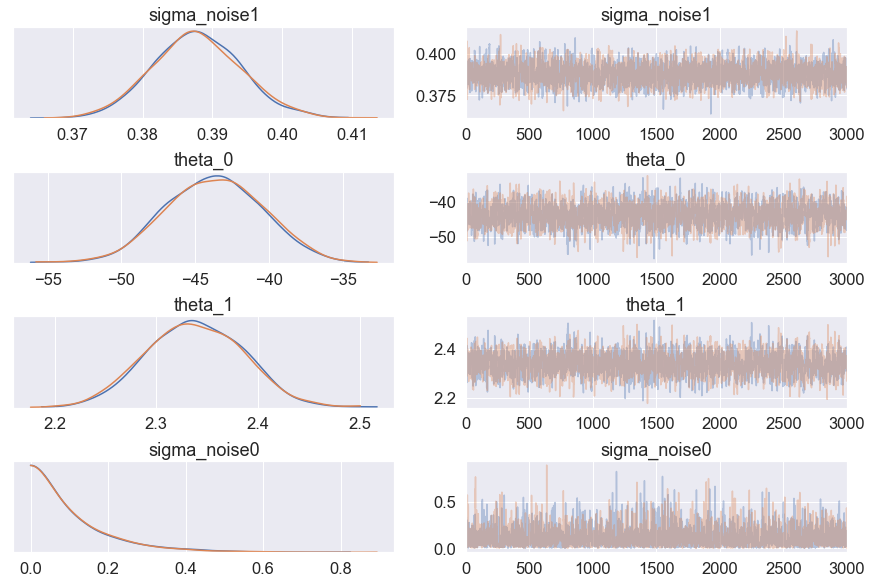

In [60]:
az.plot_trace(trace);

In [61]:
new_x = np.arange(40, 180)
with model:
    pm.set_data({'x_data': new_x})
    
    y_test = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:30<00:00, 329.22it/s]


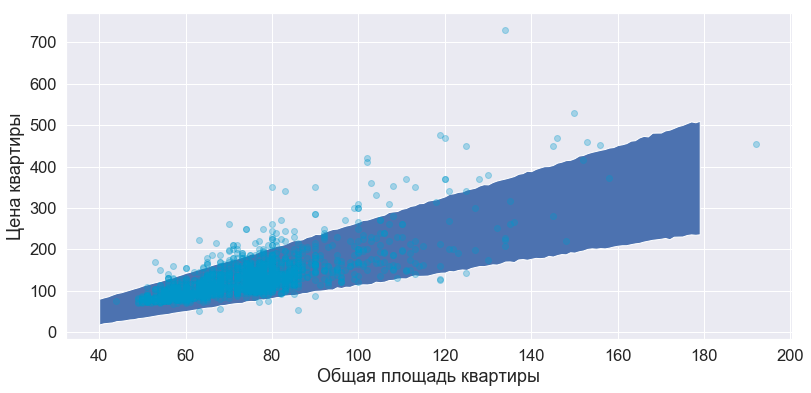

In [62]:
conv_int = []
for elem in y_test['Y'].T:
    conv_int.append([np.percentile(elem, 2.5), np.percentile(elem, 100 - 2.5)])

conv_int = np.array(conv_int)


plt.figure(figsize=(13, 6))
plt.fill_between(new_x, y1=conv_int[:,0], y2=conv_int[:,1])
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');
plt.show()

Реализуйте ту же модель, взяв для ошибок распределение Стьюдента

In [64]:
with pm.Model() as model:
    # объявим данные
    x_data = pm.Data('x_data', data['totsp'] )
    
    # априорное распределение параметра
    sigma_1 = pm.Normal('sigma_noise1', 1, 1)
    sigma_0 = pm.HalfCauchy('sigma_noise0', 10)
    theta0 = pm.Normal('theta_0', 0, 20)
    theta1 = pm.Normal('theta_1', 0, 20)
#     noise = pm.Normal('noise', 0, sigma)
    nu = pm.Exponential('nu', 2)
    # распределение данных
    Y = pm.StudentT('Y', nu=nu, mu=x_data*theta1 + theta0, sigma=sigma_1 * x_data + sigma_0, observed=data['price'])
    
    trace = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, theta_1, theta_0, sigma_noise0, sigma_noise1]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:39<00:00, 202.87draws/s]


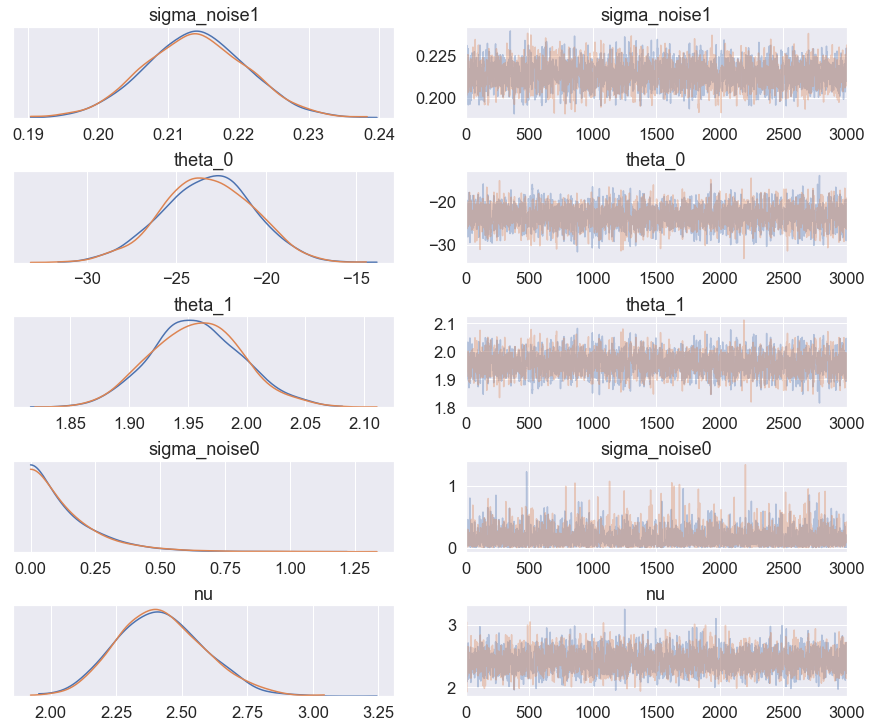

In [65]:
az.plot_trace(trace);

100%|██████████| 10000/10000 [00:29<00:00, 340.77it/s]


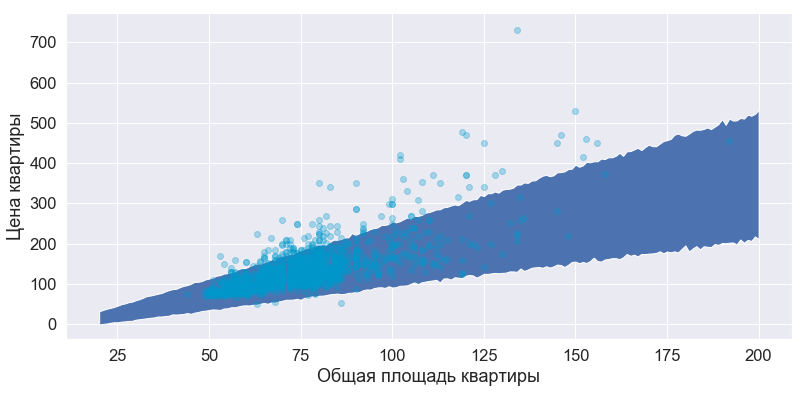

In [66]:
new_x = np.arange(20, 201)
with model:
    pm.set_data({'x_data': new_x})
    
    y_test = pm.sample_posterior_predictive(trace, samples=10000)
    
    
conv_int = []
for elem in y_test['Y'].T:
    conv_int.append([np.percentile(elem, 2.5), np.percentile(elem, 100 - 2.5)])

conv_int = np.array(conv_int)


plt.figure(figsize=(13, 6))
plt.fill_between(new_x, y1=conv_int[:,0], y2=conv_int[:,1])
plt.scatter(data['totsp'], data['price'], alpha=0.3, color=blue)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');
plt.show()

Теперь проведем небольшую аналитику. Допустим, мы хотим купить квартиру площадью 75 квадратных метров. Простройте график плотности предсказательного распределения цены такой квартиры. Посчитайте также вероятность того, что квартира площадью 75 квадратных метров имеет цену не более 100.

In [67]:
x_new = [75, 76]
with model:
    pm.set_data({'x_data': x_new})
    
    y_test = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:22<00:00, 441.87it/s]


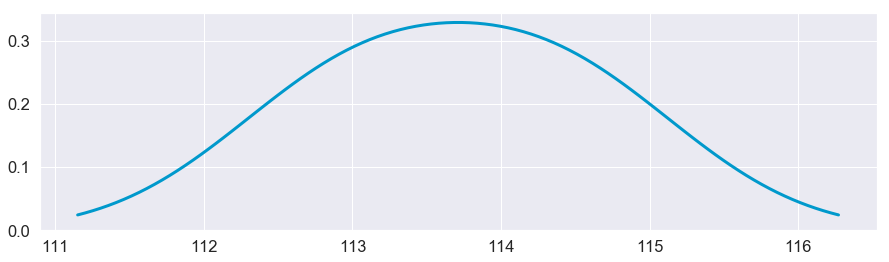

In [57]:
plt.figure(figsize=(15, 4))
sns.kdeplot(y_test['Y'][0], color=blue, lw=3)

In [69]:
(y_test['Y'][0] <=100).mean()

0.0

Насколько вообще изменяется цена квартиры при увеличении ее площади на 1 метр? Постройте для этого апостериорное распределение этого параметра, а также посчитайте среднее значение и 95%-й интервал

Это распределение theta_1, коеф-та при площади.

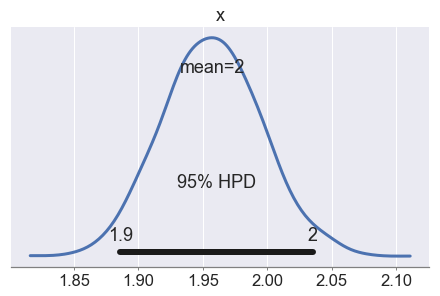

In [81]:
pm.plot_posterior(trace['theta_1'], linewidth=3, credible_interval=0.95);